## Data Preparation

In [1]:
%tensorflow_version 1.x
import tensorflow as tf
tf.__version__

TensorFlow 1.x selected.


'1.15.2'

In [2]:
from os import listdir
from numpy import asarray
import seaborn as sns
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# load all images in a directory into memory
def load_images(path, size=(512, 512)):
    data_list = list()
    for filename in listdir(path):
        pixels = load_img(path + filename, target_size=size)
        pixels = img_to_array(pixels)
        data_list.append(pixels)
        data = asarray(data_list)
    return data

In [0]:
path = '/content/drive/My Drive/Fifa_CycleGan/FIFA_Game_Frames_Neu/'
dataA = load_images(path)
dataA.shape

path = '/content/drive/My Drive/Fifa_CycleGan/FIFA_IRL_Frames_Neu/'
dataB = load_images(path)
dataB.shape

print('shape A:')
print(dataA.shape)
print('shape B:')
print(dataB.shape)

(1106, 512, 512, 3)

In [0]:

path = F"/content/drive/My Drive/Fifa_CycleGan/FIFA_IRL.npz" 
savez_compressed(path, dataA, dataB)

Loaded:  (1106, 512, 512, 3) (988, 512, 512, 3)


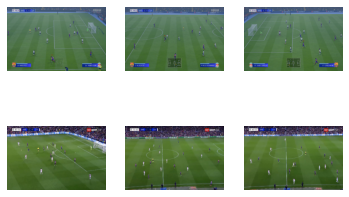

In [0]:
# load and plot the prepared dataset
from numpy import load
import matplotlib.pyplot as plt
%matplotlib inline


# load the dataset
data = load(path)
dataA, dataB = data['arr_0'], data['arr_1']
print('Loaded: ', dataA.shape, dataB.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(dataA[i].astype('uint8'), interpolation='kaiser', aspect=0.65)
# plot target image
for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + n_samples + i)
    plt.axis('off')
    plt.imshow(dataB[i].astype('uint8'), interpolation='kaiser', aspect=0.65)
#fig.tight_layout()
plt.show()

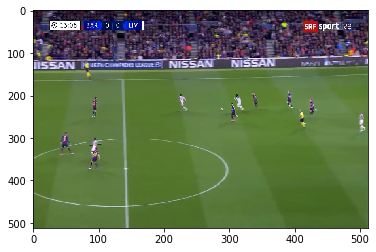

In [0]:
# load and plot the prepared dataset
from numpy import load
import matplotlib.pyplot as plt
%matplotlib inline

#data = load('FIFA_IRL.npz')
#dataA, dataB = data['arr_0'], data['arr_1']
plt.imshow(dataB[5].astype('uint8'), interpolation='nearest', aspect=0.65)
plt.show()

## Creating and Training the GAN

In [5]:
%tensorflow_version 1.x
import tensorflow as tf
tf.__version__

'1.15.2'

In [6]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-evbga74r
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-evbga74r
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101064 sha256=34eb2dc6b679bc1261e52d86e68905569cf9de7b438c56253fd49f5555cef036
  Stored in directory: /tmp/pip-ephem-wheel-cache-b168a7rc/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [0]:
%tensorflow_version 1.x
from random import random
import numpy as np
from numpy import zeros, asarray, ones, load
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model, Input
from keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Activation, Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
import seaborn as sns
sns.set()


In [8]:
%tensorflow_version 1.x
import tensorflow as tf
tf.__version__

'1.15.2'

In [0]:
# define the discriminator model
def discriminator(image_shape):
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=image_shape)
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    model = Model(in_image, patch_out)
    model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
    return model

# resnet block
def resnet_block(n_filters, input_layer):
    init = RandomNormal(stddev=0.02)
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Concatenate()([g, input_layer])
    return g


# define the standalone generator model
def generator(image_shape, n_resnet=6):
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=image_shape)
    g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    for _ in range(n_resnet):
        g = resnet_block(256, g)
    g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    out_image = Activation('tanh')(g)
    model = Model(in_image, out_image)
    return model

# define a composite model for updating generators by adversarial and cycle loss
def composite_model(g_model_1, d_model, g_model_2, image_shape):
    g_model_1.trainable = True
    d_model.trainable = False
    g_model_2.trainable = False
    input_gen = Input(shape=image_shape)
    gen1_out = g_model_1(input_gen)
    output_d = d_model(gen1_out)
    input_id = Input(shape=image_shape)
    output_id = g_model_1(input_id)
    output_f = g_model_2(gen1_out)
    gen2_out = g_model_2(input_id)
    output_b = g_model_1(gen2_out)
    model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
    return model

In [0]:
# load and plot the prepared dataset
from numpy import load
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# load and prepare training images
def load_real_samples(filename):
    data = load(filename)
    X1, X2 = data['arr_0'], data['arr_1']
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return X, y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
    X = g_model.predict(dataset)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

# save the  models 
def save_models(step, g_model_AtoB, g_model_BtoA, d_model_A, d_model_B, c_model_AtoB, c_model_BtoA):
    path = "/content/drive/My Drive/Fifa_CycleGan/" 
    filename1 = path+'g_model_AtoB_' + str(step+1) +'.h5'
    g_model_AtoB.save(filename1)
    filename2 = path+'g_model_BtoA' + str(step+1) +'.h5'
    g_model_BtoA.save(filename2)
    filename3 = path+'d_model_A_' + str(step+1) +'.h5'
    d_model_A.save(filename3) 
    filename4 = path+'d_model_B_' + str(step+1) +'.h5'
    d_model_B.save(filename4) 
    filename5 = path+'c_model_AtoB_' + str(step+1) +'.h5'
    c_model_AtoB.save(filename5) 
    filename6 = path+'c_model_BtoA_' + str(step+1) +'.h5'
    c_model_BtoA.save(filename6) 
    print('>Saved: %s, %s, %s, %s, %s and %s' % (filename1, filename2, filename3, filename4, filename5, filename6))


# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, trainX, n_samples=3):
    X_in, _ = generate_real_samples(trainX, n_samples, 0)
    X_out, _ = generate_fake_samples(g_model, X_in, 0)
    # scale all pixels from 0 to 1
    X_in = (X_in + 1) / 2.0
    X_out = (X_out + 1) / 2.0
    for i in range(n_samples):
        plt.subplot(2, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_in[i], interpolation='kaiser', aspect=0.65)
    for i in range(n_samples):
        plt.subplot(2, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_out[i], interpolation='kaiser', aspect=0.65)
    path = "/content/drive/My Drive/Fifa_CycleGan/" 
    filename1 = path+'_generated_plot_' + str(step+1) + '.png'
    plt.tight_layout()
    plt.savefig(filename1, dpi=700)
    plt.close()


# update image pool for fake images
def update_pool(pool, images, max_size=50):
    selected = list()
    for image in images:
        if len(pool) < max_size:
            pool.append(image)
            selected.append(image)
        elif random() < 0.5:
            selected.append(image)
        else:
            ix = randint(0, len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    return asarray(selected)

# train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, start=0, n_epochs = 100):
    n_batch = 1
    n_patch = d_model_A.output_shape[1]
    trainA, trainB = dataset
    poolA, poolB = list(), list()
    bat_per_epo = int(len(trainA) / n_batch)
    n_steps = bat_per_epo * n_epochs
    iteration = []
    g_loss2_list = []
    dA_loss1_list = []
    dA_loss2_list = []
    g_loss1_list = []
    dB_loss1_list = []
    dB_loss2_list =  []
    loss_list = []
    for i in range(start, n_steps):
        X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
        X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
        X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
        X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
        X_fakeA = update_pool(poolA, X_fakeA)
        X_fakeB = update_pool(poolB, X_fakeB)
        g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
        dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
        dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
        g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
        dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
        dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
        iteration.append(i)
        g_loss2_list.append(g_loss2)
        dA_loss1_list.append(dA_loss1)
        dA_loss2_list.append(dA_loss2)
        g_loss1_list.append(g_loss1)
        dB_loss1_list.append(dB_loss1)
        dB_loss2_list.append(dB_loss2)
        print('>%d/%d, Losses: DiscrA[%.3f,%.3f] DiscrB[%.3f,%.3f] Generator[%.3f,%.3f]' % (i+1, n_steps, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
        if len(g_loss1_list)> 110:
          print('Generator MedLoss100: [%.3f,%.3f], StdLoss100: [%.3f,%.3f]' % (np.median(g_loss1_list[-100:-1]), np.median(g_loss2_list[-100:-1]), np.std(g_loss1_list[-100:-1]), np.std(g_loss2_list[-100:-1])))
        if (i+1) % (1000) == 0:
          loss_list = []
          loss_list.append(g_loss2_list)
          loss_list.append(dA_loss1_list)
          loss_list.append(dA_loss2_list)
          loss_list.append(g_loss1_list)
          loss_list.append(dB_loss1_list)
          loss_list.append(dB_loss2_list)
          # Plot Losses
          plt.figure(figsize=(12,9))
          plt.xlabel("Iteration")
          plt.ylabel("Loss")
          plt.title("FIFA CycleGan Loss")
          loss_strings = ['g_loss2', 'dA_loss1', 'dA_loss2', 'g_loss1', 'dB_loss1', 'dB_loss2']
          for ix in range(len(loss_list)):
            plt.plot(iteration, loss_list[ix],label = loss_strings[ix])
          plt.legend(loc=1)
          path = "/content/drive/My Drive/Fifa_CycleGan/" 
          filename_loss_plot = path+'_loss_plot_' + str(i+1) + '.png'
          plt.savefig(filename_loss_plot, dpi=700)
          plt.close()
          summarize_performance(i, g_model_AtoB, trainA)
          save_models(i, g_model_AtoB, g_model_BtoA, d_model_A, d_model_B, c_model_AtoB, c_model_BtoA)
      

In [18]:
liste = list(np.arange(1,200))
np.std(liste[-10:-1])


g_loss1 = list(np.arange(1,200))
g_loss2 = list(np.arange(1,200))
print('MedLoss100: [%.3f,%.3f] StdLoss100: [%.3f,%.3f]' % (np.median(g_loss1[-100:-1]), np.median(g_loss2[-100:-1]), np.std(g_loss1[-100:-1]), np.std(g_loss2[-100:-1])))


MedLoss100: Generator[149.000,149.000] StdLoss100: Generator[28.577,28.577]


### Train first  time

In [0]:
from keras.utils.vis_utils import plot_model

path = F"/content/drive/My Drive/Fifa_CycleGan/FIFA_IRL.npz" 
dataset = load_real_samples(path)
print('Loaded', dataset[0].shape, dataset[1].shape)
image_shape = dataset[0].shape[1:]
g_model_AtoB = generator(image_shape)
g_model_BtoA = generator(image_shape)
d_model_A = discriminator(image_shape)
d_model_B = discriminator(image_shape)
c_model_AtoB = composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
c_model_BtoA = composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

# Train GAN
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

Loaded (1106, 512, 512, 3) (988, 512, 512, 3)


### Resume Training

In [13]:
step =  91000
path = F"/content/drive/My Drive/Fifa_CycleGan/FIFA_IRL.npz" 
dataset = load_real_samples(path)
print('Loaded', dataset[0].shape, dataset[1].shape)
image_shape = dataset[0].shape[1:]
from keras.models import load_model

path = "/content/drive/My Drive/Fifa_CycleGan/" 
filename_g_model_AtoB_ = path+'g_model_AtoB_'  + str(step) +'.h5'
filename_g_model_BtoA = path+'g_model_BtoA'  + str(step) +'.h5'
filename_d_model_A_ = path+'d_model_A_'  + str(step) +'.h5'
filename_d_model_B_ = path+'d_model_B_'  + str(step) +'.h5'
filename_c_model_AtoB_ = path+'c_model_AtoB_'  + str(step) +'.h5'
filename_c_model_BtoA_ = path+'c_model_BtoA_'  + str(step) +'.h5'

cust = {'InstanceNormalization': InstanceNormalization}
g_model_AtoB = load_model(filename_g_model_AtoB_, cust)
g_model_BtoA = load_model(filename_g_model_BtoA, cust)
d_model_A = load_model(filename_d_model_A_, cust)
d_model_B = load_model(filename_d_model_B_, cust)
c_model_AtoB = load_model(filename_c_model_AtoB_, cust)
c_model_BtoA = load_model(filename_c_model_BtoA_, cust)

# train GAN
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, start = step)

Loaded (1106, 512, 512, 3) (988, 512, 512, 3)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Streaming output truncated to the last 5000 lines.
Generator MedLoss100: [0.207,0.176], StdLoss100: [0.031,0.026]
>108103/110600, Losses: DiscrA[0.000,0.000] DiscrB[0.000,0.000] Generator[0.175,0.156]
Generator MedLoss100: [0.207,0.176], StdLoss100: [0.031,0.026]
>108104/110600, Losses: DiscrA[0.000,0.000] DiscrB[0.000,0.000] Generator[0.191,0.162]
Generator MedLoss100: [0.207,0.176], StdLoss100: [0.031,0.026]
>108105/110600, Losses: DiscrA[0.000,0.000] DiscrB[0.000,0.000] Generator[0.184,0.143]
Generator MedLoss100: [0.207,0.176], StdLoss100: [0.031,0.026]
>108106/110600, Losses: DiscrA[0.000,0.000] DiscrB[0.000,0.000] Generator[0.201,0.168]
Generator MedLoss100: [0.207,0.176], StdLoss100: [0.031,0.026]
>108107/110600, Losses: DiscrA[0.000,0.000] DiscrB[0.000,0.000] Generator[0.203,0.170]
Generator MedLoss100: [0.207,0.176], StdLoss100: [0.031,0.026]
>108108/110600, Losses: DiscrA[0.000,0.000] DiscrB[0.000,0.000] Generator[0.179,0.150]
Generator MedLoss100: [0.207,0.176], StdLoss100: 

## Apply Style

In [0]:
%tensorflow_version 1.x
import tensorflow as tf
tf.__version__

'1.15.2'

In [0]:
from keras.models import load_model
from numpy import load
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

# load and prepare training images
def load_real_samples(filename):
    data = load(filename)
    X1 = data['arr_0']
    X2 = data['arr_1']
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

path = F"/content/drive/My Drive/Fifa_CycleGan/FIFA_IRL.npz" 
#A_data, B_data = load_real_samples(path)
print('Loaded', A_data.shape, B_data.shape)

step =  9000
path = "/content/drive/My Drive/Fifa_CycleGan/" 
filename_g_model_AtoB_ = path+'g_model_AtoB_'  + str(step) +'.h5'
filename_g_model_BtoA = path+'g_model_BtoA'  + str(step) +'.h5'

cust = {'InstanceNormalization': InstanceNormalization}
g_model_AtoB = load_model(filename_g_model_AtoB_, cust)
#g_model_BtoA = load_model(filename_g_model_BtoA, cust)

# select a random sample of images from the dataset
def select_sample(dataset, n_samples):
    idx = randint(0, dataset.shape[0], n_samples)
    X = dataset[idx]
    return X

Loaded (1106, 512, 512, 3) (988, 512, 512, 3)


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_final(real, generaterd, filename1 = 'final'):
  real = (real + 1) / 2.0
  generaterd = (generaterd + 1) / 2.0
  n_samples= len(real)
  for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(real[i], interpolation='kaiser', aspect=0.65)
  for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + n_samples + i)
    plt.axis('off')
    plt.imshow(generaterd[i], interpolation='kaiser', aspect=0.65)
  #plt.show()
  plt.tight_layout()
  plt.savefig(filename1, dpi=700)
  plt.close()

In [0]:
A_real = select_sample(A_data, 1)
B_generated  = g_model_AtoB.predict(A_real)
show_final(A_real, B_generated)

In [0]:
# Prepare for SRGAN
A_real = select_sample(A_data, 10)
B_generated  = g_model_AtoB.predict(A_real)
B_generated = (B_generated + 1) / 2.0
B_generated = (B_generated * 255).astype(np.uint8)
import cv2
img_cyclegan_resized = cv2.resize(B_generated[0], (200,200), interpolation = cv2.INTER_AREA)

In [0]:
10000//1000

10

In [0]:
# Plot for different Epochs
#A_real = select_sample(A_data, 1)
for step in list(np.arange(1000, 11000, 1000)):
  epoch = step//1000
  path = "/content/drive/My Drive/Fifa_CycleGan/" 
  filename_g_model_AtoB_ = path+'g_model_AtoB_'  + str(step) +'.h5'
  cust = {'InstanceNormalization': InstanceNormalization}
  g_model_AtoB = load_model(filename_g_model_AtoB_, cust)
  result  = g_model_AtoB.predict(A_real)
  show_final(A_real, result, filename1 = str(step))

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


# SRGAN


In [0]:
# Import Dependencies
import os,shutil
import cv2
import numpy as np
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from keras.models import Input, Model
from keras.layers import BatchNormalization, LeakyReLU, Conv2D, Dense, \
                         Flatten, Add, PReLU, Conv2DTranspose, Lambda, UpSampling2D                    
from keras.optimizers import Adam
from keras.applications import VGG19
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

In [0]:
# load all images in a directory into memory
def load_images(path, size=(512, 512)):
    data_list = list()
    for filename in listdir(path):
      pixels = load_img(path + filename, target_size=size)
      # convert to numpy array
      pixels = img_to_array(pixels)
      # store
      data_list.append(pixels)
      return asarray(data_list)

In [0]:
# load all images in a directory into memory
def load_images(path, size=(512, 512)):
    data_list = list()
    for filename in listdir(path):
        pixels = load_img(path + filename, target_size=size)
        pixels = img_to_array(pixels)
        data_list.append(pixels)
        data = asarray(data_list)
    return data

In [23]:
path = '/content/drive/My Drive/Fifa_CycleGan/FIFA_IRL_Frames_Neu/'
high_reso_imgs = load_images(path, size=(800, 800))
low_reso_imgs = load_images(path, size=(200, 200))
print(len(high_reso_imgs))
print(len(low_reso_imgs))


988
988


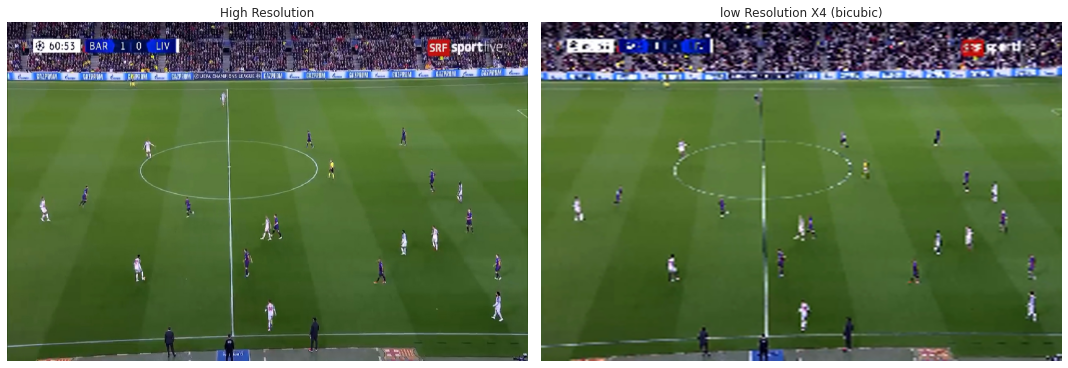

In [26]:
plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.imshow(high_reso_imgs[2].astype('uint8'), interpolation='kaiser', aspect=0.65)
plt.grid('off')
plt.axis('off')
plt.title('High Resolution')
plt.subplot(1,2,2)
plt.imshow(cv2.resize(low_reso_imgs[2].astype('uint8'),(800,800), interpolation = cv2.INTER_CUBIC), interpolation='kaiser', aspect=0.65)
plt.grid('off')
plt.axis('off')
_=plt.title('low Resolution X4 (bicubic)')
filename1 = 'SRGAN_real_X4.png'
plt.tight_layout()
plt.savefig(filename1, dpi=1000)

In [0]:
# Creating the model
# Source: https://github.com/eriklindernoren/Keras-GAN/blob/master/srgan/srgan.py
class SRGAN():
  # Implementation of SRGAN from paper:
  # https://arxiv.org/abs/1609.04802
    def __init__(self,lr_height = 200,lr_width = 200,channels = 3,
              upscale_factor = 4, generator_lr = 1e-4, discriminator_lr = 1e-4, gan_lr = 1e-4):
        self.height_low_reso = lr_height
        self.width_low_reso = lr_width

        if upscale_factor % 2 != 0:
            raise ValueError('Upscale factor is invalid, must be product of 2')

        self.upscale_factor = upscale_factor
        self.height_high_reso = self.height_low_reso * self.upscale_factor
        self.width_high_reso = self.width_low_reso * self.upscale_factor

        self.channels = channels
        self.shape_low_reso = (self.height_low_reso,self.width_low_reso,self.channels)
        self.shape_high_reso = (self.height_high_reso,self.width_high_reso,self.channels)
        self.samples = high_reso_imgs.shape[0]

        opti_generator = Adam(generator_lr,0.9)
        opti_discriminator = Adam(discriminator_lr,0.9)
        opti_gan = Adam(gan_lr,0.9) 

        self.vgg = self.bulid_vgg()

        self.discriminator = self.build_discriminator(opti_discriminator)
        self.discriminator.trainable = False
        self.generator = self.build_generator(opti_generator)
        self.srgan = self.build_srgan(opti_gan)

    def save_GAN_Model(self,epoch):
        self.srgan.save_weights('/content/drive/My Drive/Fifa_CycleGan/SRGAN/srgan_weights_epoch_%d.h5' % epoch)


    def plotLosses(self,dlosses,glosses,epo):
        fig, ax1 = plt.subplots(figsize = (10,12))
        color = 'tab:blue'
        ax1.plot(dlosses,color = color, label = 'Dis loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Dis loss', color = color)
        ax1.tick_params('y',color = color)
        color = 'tab:green'
        ax2 = ax1.twinx()
        ax2.plot(glosses, color = color, label = 'Gen loss')
        ax2.set_ylabel('Gen loss', color = color)
        ax2.tick_params('y', color = color)
        plt.title('Discriminator & Generator Losses')
        plt.savefig('/content/drive/My Drive/Fifa_CycleGan/SRGAN/Losses_%d.png' % epo)
        plt.show()

    def gen_pipeline(self, batch_size = 16):
        while(1):
            indx_high = np.random.randint(0,high_reso_imgs.shape[0]-1,batch_size)
            indx_low = np.random.randint(0,low_reso_imgs.shape[0]-1,batch_size)   
            real = np.ones((batch_size,) + self.discriminator.output_shape[1:])
            fake = np.zeros((batch_size,) + self.discriminator.output_shape[1:])
            norm_hr = high_reso_imgs[indx_high]/127.5-1
            norm_lr = low_reso_imgs[indx_low]/127.5 -1
            yield(norm_hr,real,norm_lr,fake)
            
    def vgg_pipeline(self, batch_size = 16):
      while(1):
        indx = np.random.randint(0,high_reso_imgs.shape[0]-1,batch_size)
        real = np.ones((batch_size,) + self.discriminator.output_shape[1:])
        norm_hr = high_reso_imgs[indx]/127.5-1
        norm_lr = low_reso_imgs[indx]/127.5 -1
        yield(norm_hr,norm_lr,real)
            
      
    def bulid_vgg(self):
        vgg = VGG19(weights = "imagenet")
#         vgg.summary()
        vgg.outputs = [vgg.layers[9].output]
        img = Input(shape = self.shape_high_reso)
        img_features = vgg(img)
        vgg_model = Model(img, img_features)
#         for layer in vgg_model.layers:
#             layer.trainable = False
        vgg_model.compile(loss = 'mse', optimizer = Adam(0.0002,0.5),
                         metrics =['acc'])
        return vgg_model


    def residual_block(self,input_layer):
        x = Conv2D(filters = 64, kernel_size = 3, padding = 'same')(input_layer)
        x = BatchNormalization(momentum=0.8)(x)
        x = PReLU()(x)
        x = Conv2D(filters = 64, kernel_size = 3, padding = 'same')(x)
        x = BatchNormalization(momentum=0.8)(x)
        return Add()([input_layer,x])

    def disc_block(self,layer, n_filters, batch_norm = True):
        x = Conv2D(filters = n_filters, kernel_size = 3, padding = 'same')(layer)
        if batch_norm:
            x = BatchNormalization(momentum=0.8)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters = n_filters, kernel_size = 3,
                   strides=2, padding = 'same')(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = LeakyReLU(alpha=0.2)(x)
        return x

    def Upsample_Block(self,x_in):
        x = Conv2D(filters = 256, kernel_size=3, padding='same')(x_in)
        x = self.SubpixelConv2D(2)(x)
        return PReLU()(x)
      
    def SubpixelConv2D(self,scale):
        return Lambda(lambda x: tf.depth_to_space(x, scale))
  
    def build_generator(self,opti_generator,n_blocks = 16):
        input_layer = Input(self.shape_low_reso)
        
        first_layer = Conv2D(filters = 64, kernel_size = 9,
                             padding = 'same')(input_layer)
        
        first_layer = PReLU()(first_layer)
        
        residual_blocks = self.residual_block(first_layer)
        
        for _ in range(n_blocks-1):
            residual_blocks = self.residual_block(residual_blocks)

        output_residual = Conv2D(filters = 64, kernel_size = 3,
                             padding = 'same')(residual_blocks)
        
        output_residual = BatchNormalization(momentum=0.8)(output_residual)
        
        output_residual = Add()([output_residual,first_layer])
               
        upsample_layer = self.Upsample_Block(output_residual)
        
        for _ in range(self.upscale_factor//2-1):
            upsample_layer =  self.Upsample_Block(upsample_layer)
            
        gen_output = Conv2D(filters = 3, kernel_size = 9,
                            padding = 'same', activation = 'tanh')(upsample_layer)

        gen_model = Model(inputs = input_layer, outputs = gen_output)
        gen_model.compile(loss = 'binary_crossentropy', optimizer = opti_generator)

        return gen_model

    def build_discriminator(self,opti_discriminator,n_blocks = 3, n_filters = 64):
        input_layer = Input(self.shape_high_reso)
        discriminator_blocks = self.disc_block(input_layer,n_filters,False)
        for i in range(n_blocks):
            discriminator_blocks = self.disc_block(discriminator_blocks, 
                                             n_filters = (i+1)*2*n_filters)
        
        #f_layer = GlobalAveragePooling2D()(discriminator_blocks)
        f_layer = Dense(units = 1024)(discriminator_blocks)
        f_layer = LeakyReLU(alpha=0.2)(f_layer)
        dis_output = Dense(units = 1, activation = 'sigmoid')(f_layer)
        disc_model = Model(inputs = input_layer, outputs = dis_output)
        disc_model.compile(loss = 'mse', optimizer = opti_discriminator,
                          metrics = ['accuracy'])

        return disc_model

    def build_srgan(self,optimizer):
        dis_input = Input(self.shape_high_reso)
        gen_input = Input(self.shape_low_reso)

        generated_high_reso = self.generator(gen_input)
        generated_features = self.vgg(generated_high_reso)
        generator_valid = self.discriminator(generated_high_reso)


        gan_model = Model(inputs = [gen_input, dis_input], 
                          outputs = [generator_valid, generated_features])
        
        for l in gan_model.layers[-1].layers[-1].layers:
          l.trainable=False
        
        gan_model.compile(loss = ['binary_crossentropy','mse'], loss_weights = [1e-2,1], optimizer = 'adam')
        gan_model.summary()
        return gan_model



    def train(self, epochs, save_interval = 100, batch_size = 16):
        pipeline = self.gen_pipeline(batch_size)
        vgg_pipeline = self.vgg_pipeline(batch_size)

        batch_count = self.samples // batch_size
        dlosses = []
        glosses = []
        for epo in range(1,epochs+1):
            print ('-'*15,'Epoch %d' % epo, '-'*15)
            for _ in tqdm(range(batch_count)):

                ##########################

                # Train the Discriminator

                ##########################

                # Generate Batch
                hr_imgs, real, lr_imgs, fake = next(pipeline)

                # Generate high resolution photos from low resolution photos
                generated_hr_imags = self.generator.predict(lr_imgs)

                # Train the discriminator 
                real_dis_loss = self.discriminator.train_on_batch(hr_imgs,real)
                fake_dis_loss = self.discriminator.train_on_batch(generated_hr_imags,fake)
                dis_loss = (0.5*np.add(real_dis_loss,fake_dis_loss))

                ##########################

                # Train the Generator

                ##########################

                #Generate Batch
                hr_imgs, lr_imgs, real = next(vgg_pipeline)

                # Extract ground truth using VGG model
                img_features = self.vgg.predict(hr_imgs)

                gan_loss = self.srgan.train_on_batch([lr_imgs,hr_imgs], [real, img_features])


            if epo % save_interval == 0:
              self.save_GAN_Model(epo)
              self.plotLosses(dlosses,glosses,epo)
            dlosses.append(gan_loss[1])
            glosses.append(gan_loss[0])
            print('\n',dlosses[-1],glosses[-1])

In [28]:
model_srgan = SRGAN()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

574717952/574710816 [==============================] - 14s 0us/step
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
model_3 (Model)                 (None, 800, 800, 3)  96273667    input_6[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 50, 50, 1)    3759681     model_3[1][0]                    
______________________________________________

--------------- Epoch 1 ---------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:198: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'




 3.256332 4.227708
--------------- Epoch 2 ---------------


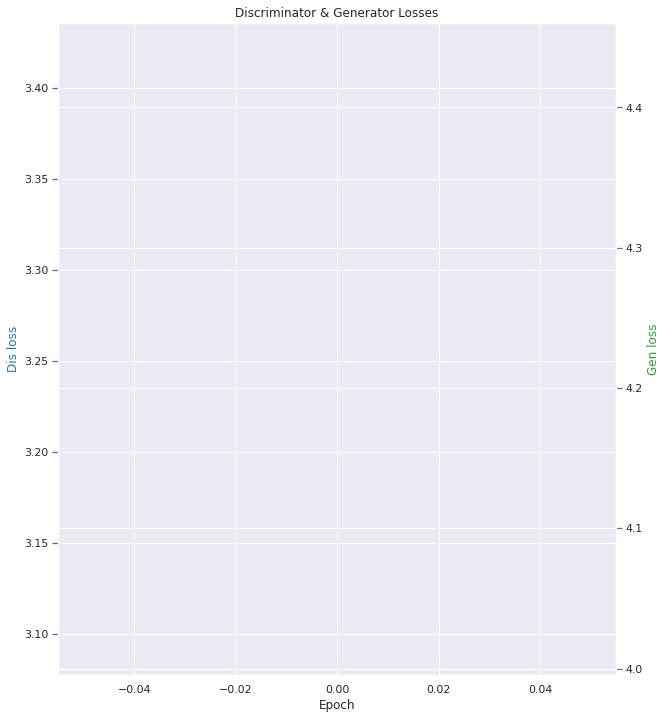


 5.176085 5.476071
--------------- Epoch 3 ---------------




 6.4996386 4.952691
--------------- Epoch 4 ---------------


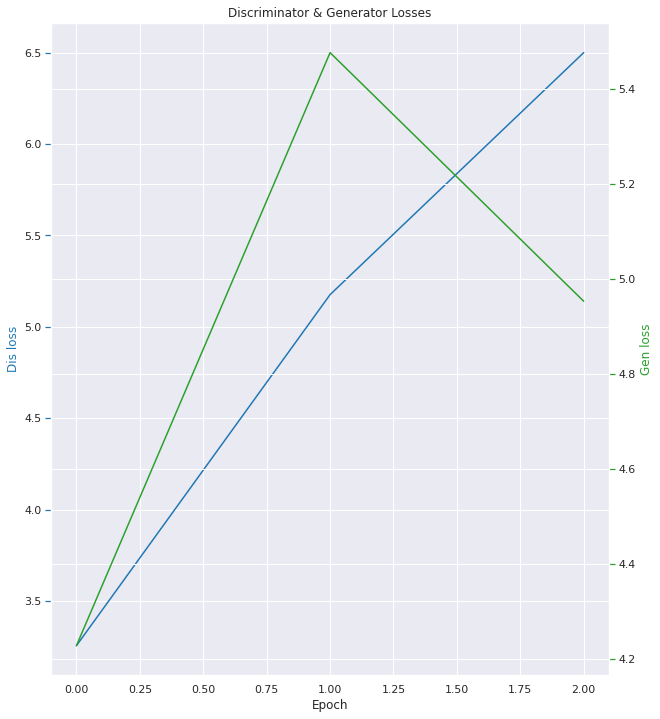


 5.1117597 3.8784716
--------------- Epoch 5 ---------------




 6.0237417 3.4624562
--------------- Epoch 6 ---------------


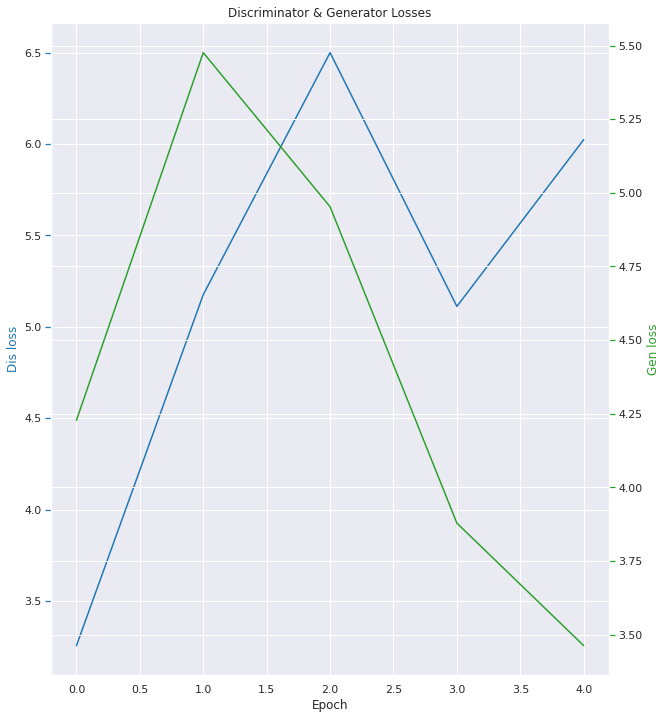


 8.093263 4.338288
--------------- Epoch 7 ---------------




 7.9726896 3.3301046
--------------- Epoch 8 ---------------


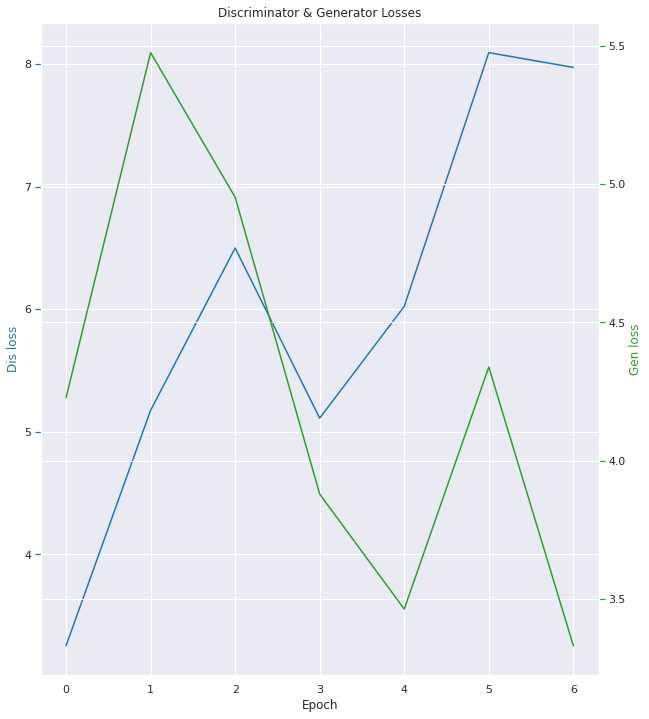


 8.515254 3.870635
--------------- Epoch 9 ---------------




 7.6328955 2.043001
--------------- Epoch 10 ---------------


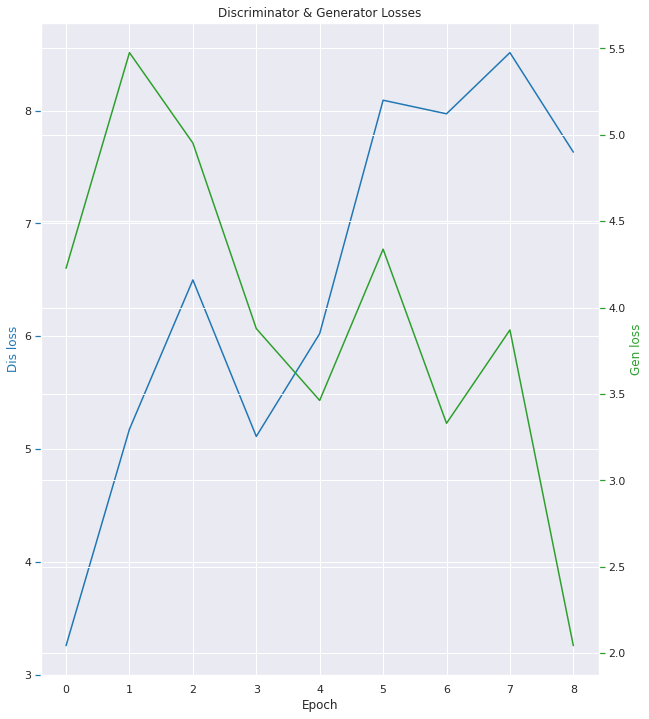


 8.683424 2.7947304
--------------- Epoch 11 ---------------




 9.196326 2.415242
--------------- Epoch 12 ---------------


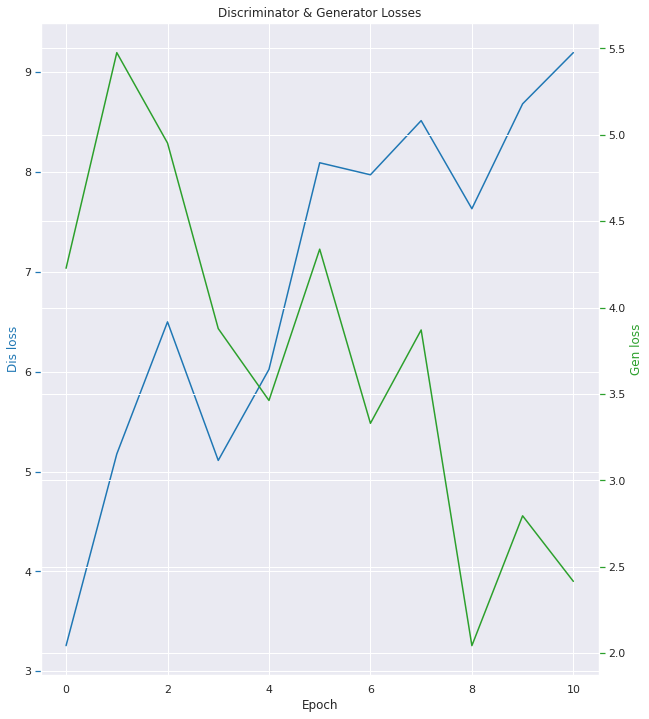

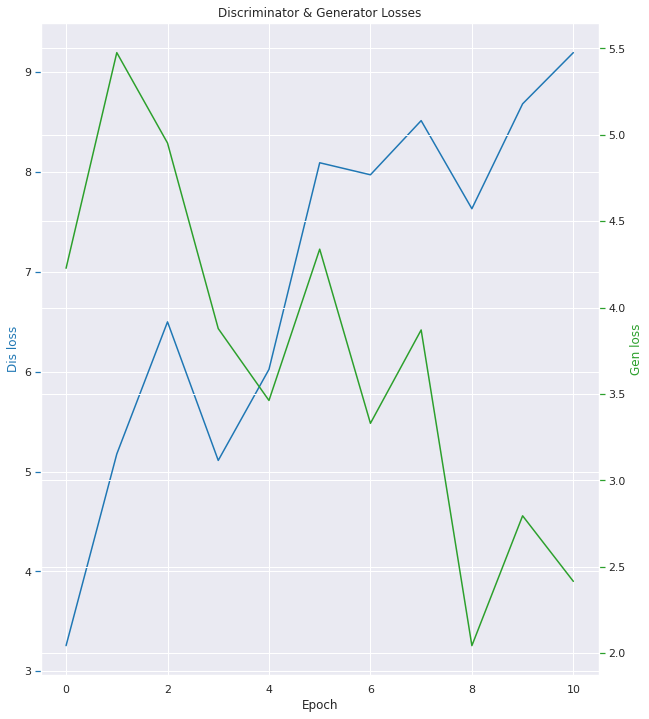

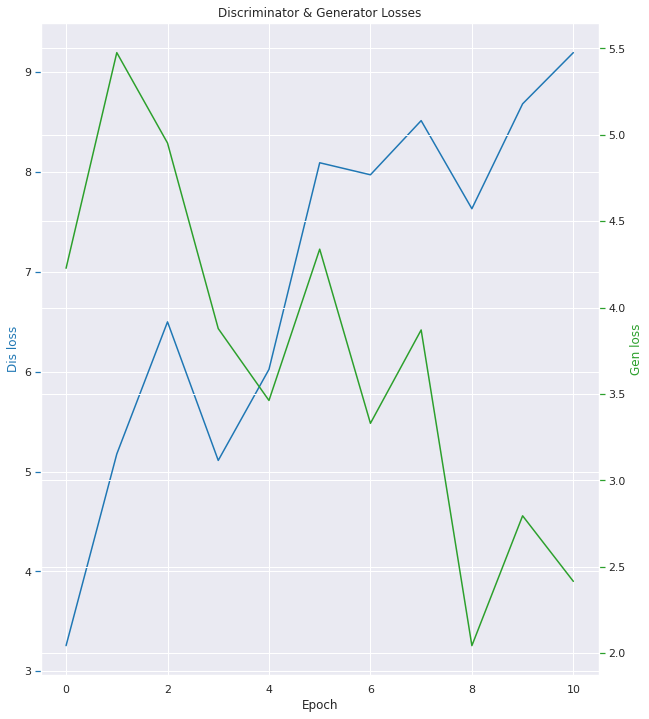


 8.921663 3.2714052
--------------- Epoch 13 ---------------

 8.921663 3.2714052
--------------- Epoch 13 ---------------

 8.921663 3.2714052
--------------- Epoch 13 ---------------




 8.553625 2.692541
--------------- Epoch 14 ---------------


 8.553625 2.692541
--------------- Epoch 14 ---------------


 8.553625 2.692541
--------------- Epoch 14 ---------------


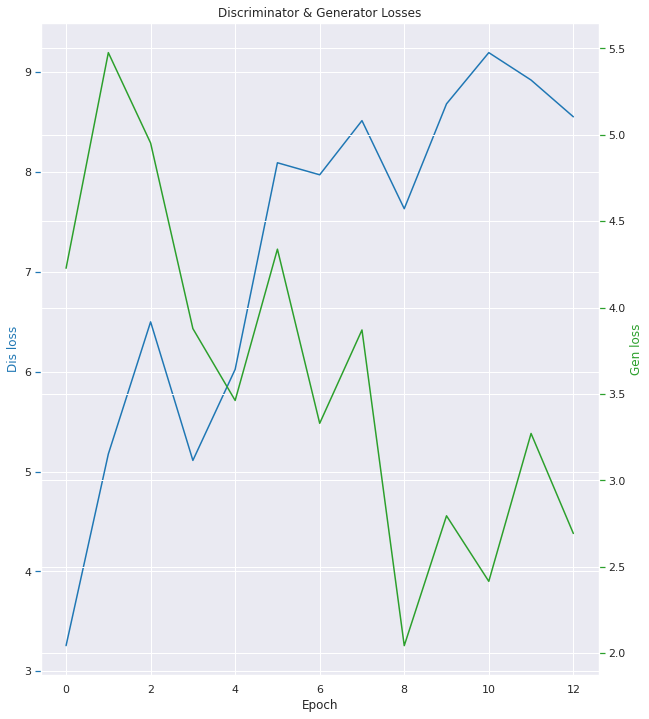

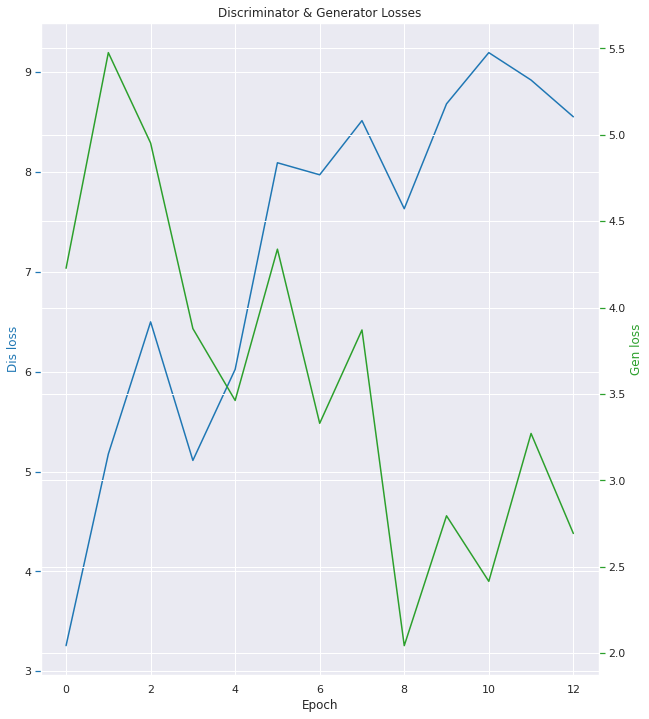

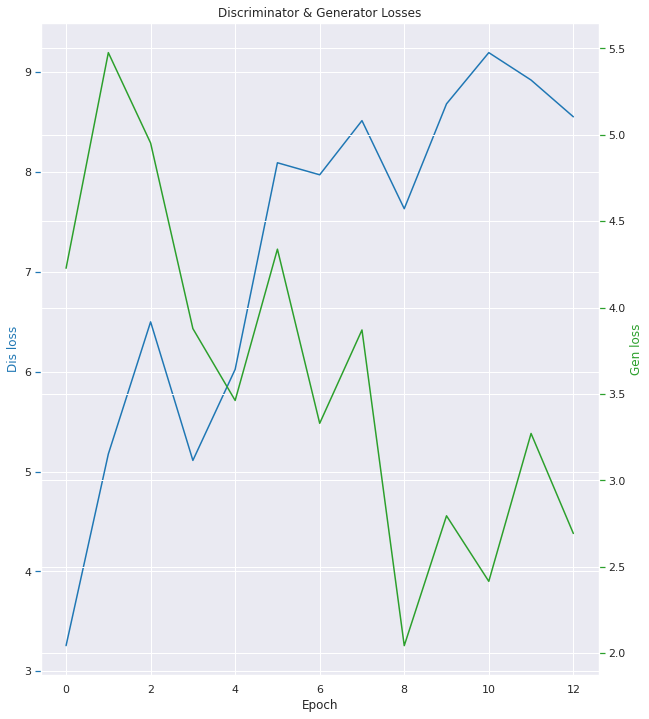


 9.573435 2.9504848
--------------- Epoch 15 ---------------

 9.573435 2.9504848
--------------- Epoch 15 ---------------

 9.573435 2.9504848
--------------- Epoch 15 ---------------




 9.31543 1.761361
--------------- Epoch 16 ---------------


 9.31543 1.761361
--------------- Epoch 16 ---------------


 9.31543 1.761361
--------------- Epoch 16 ---------------


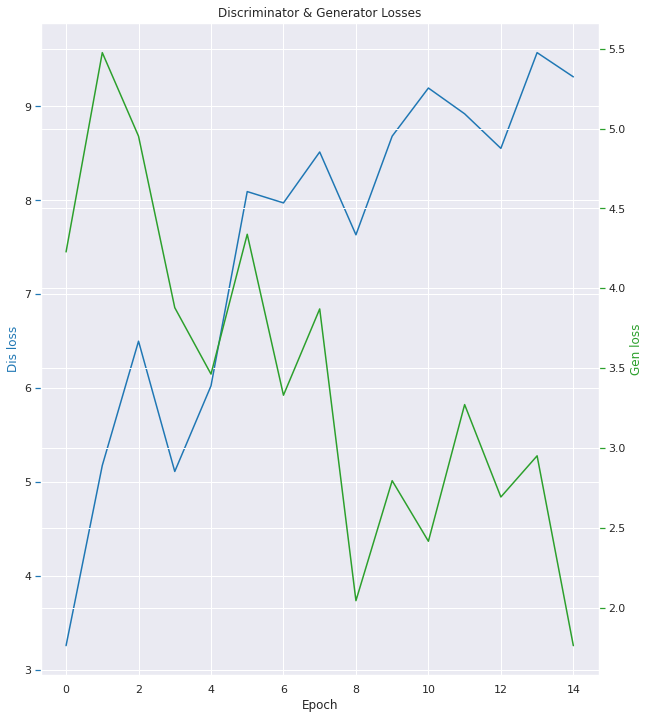

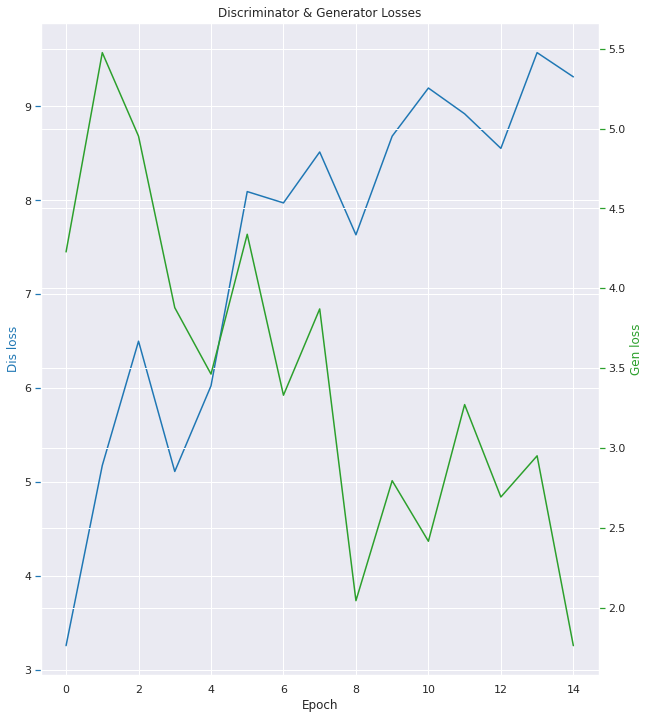

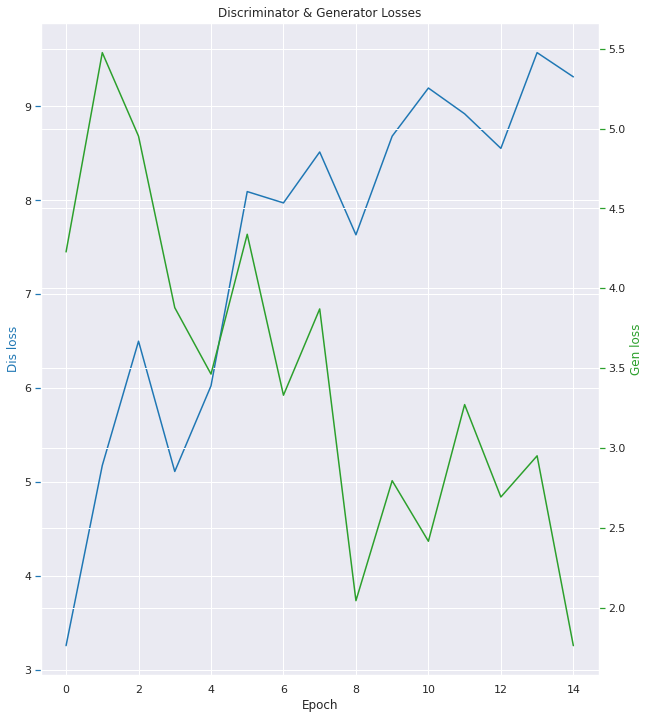


 8.997667 2.0346794
--------------- Epoch 17 ---------------

 8.997667 2.0346794
--------------- Epoch 17 ---------------

 8.997667 2.0346794
--------------- Epoch 17 ---------------




 9.063673 1.7972354
--------------- Epoch 18 ---------------


 9.063673 1.7972354
--------------- Epoch 18 ---------------


 9.063673 1.7972354
--------------- Epoch 18 ---------------


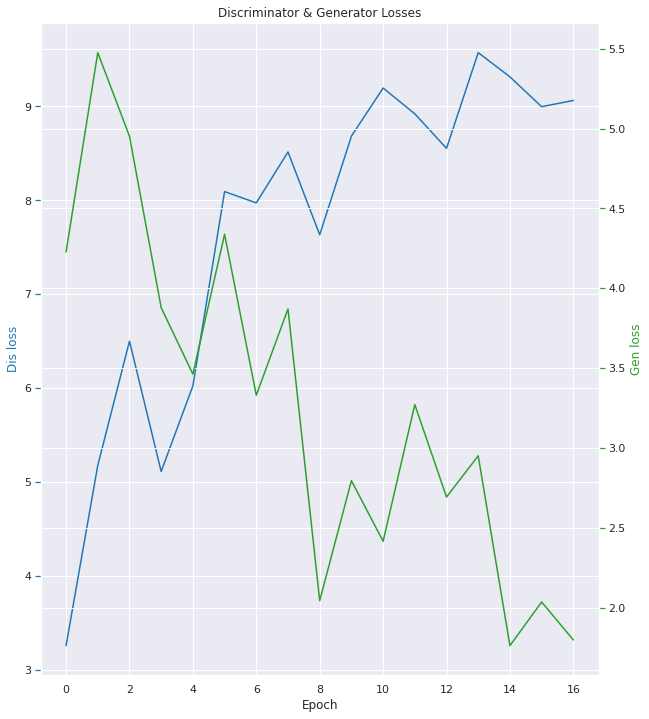

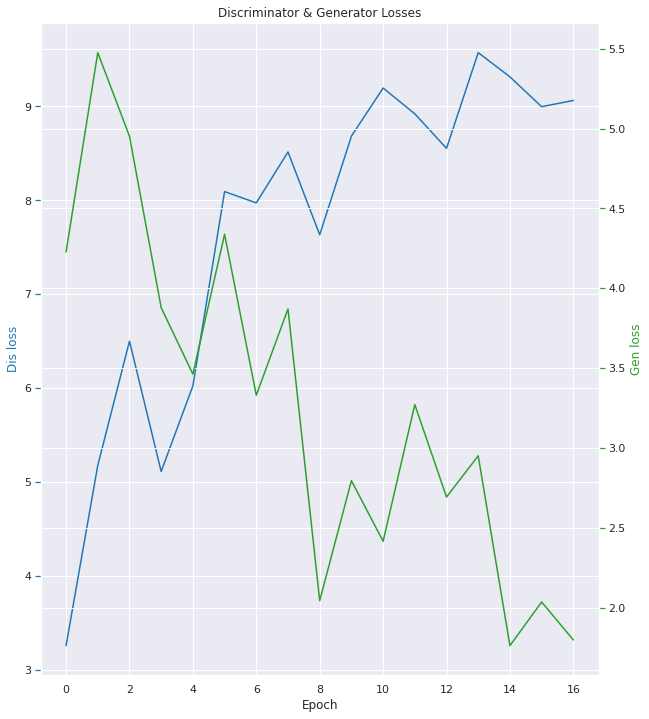

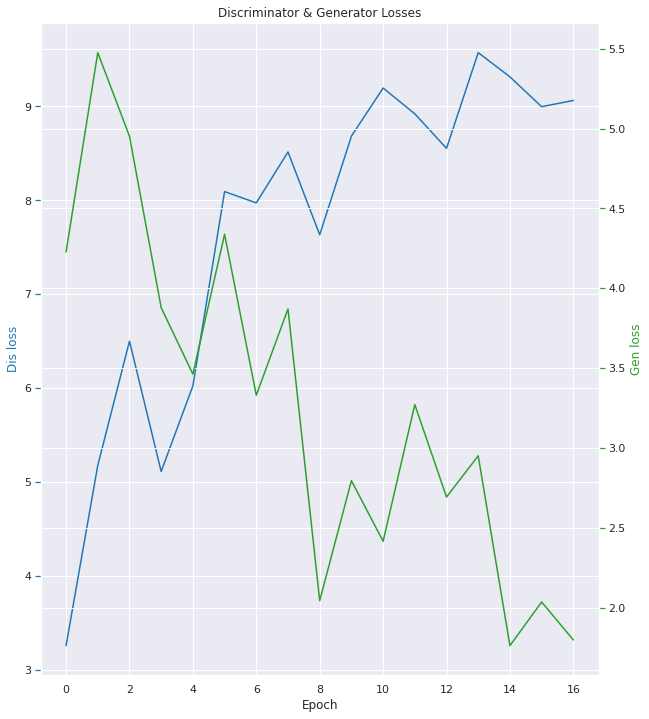


 9.440626 2.076635
--------------- Epoch 19 ---------------

 9.440626 2.076635
--------------- Epoch 19 ---------------

 9.440626 2.076635
--------------- Epoch 19 ---------------




 10.022269 2.2632418
--------------- Epoch 20 ---------------


 10.022269 2.2632418
--------------- Epoch 20 ---------------


 10.022269 2.2632418
--------------- Epoch 20 ---------------


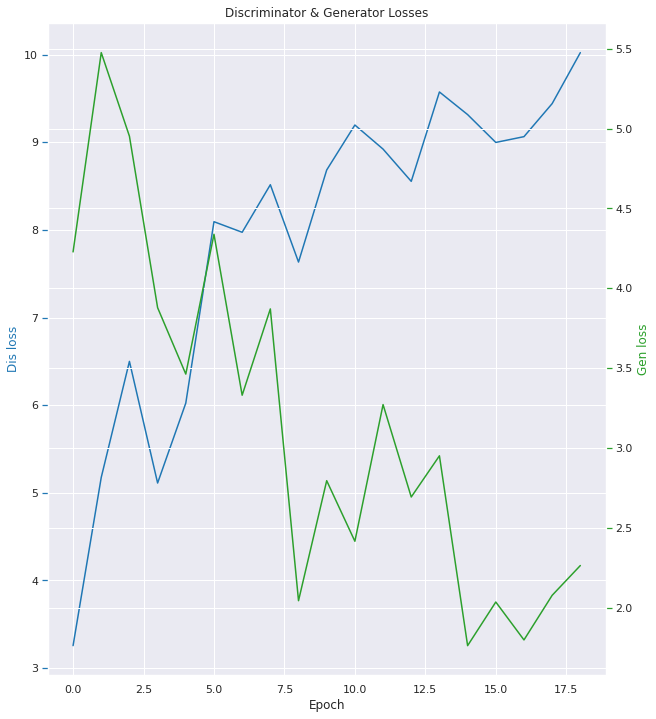

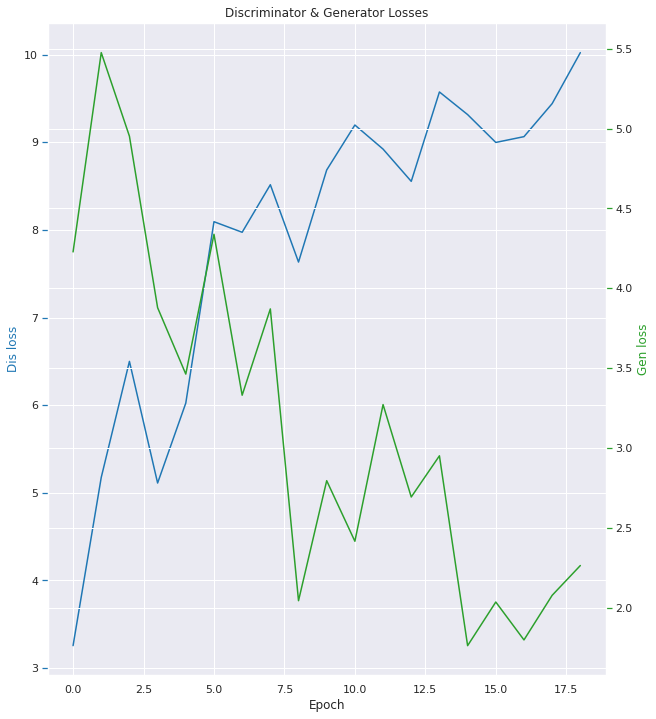

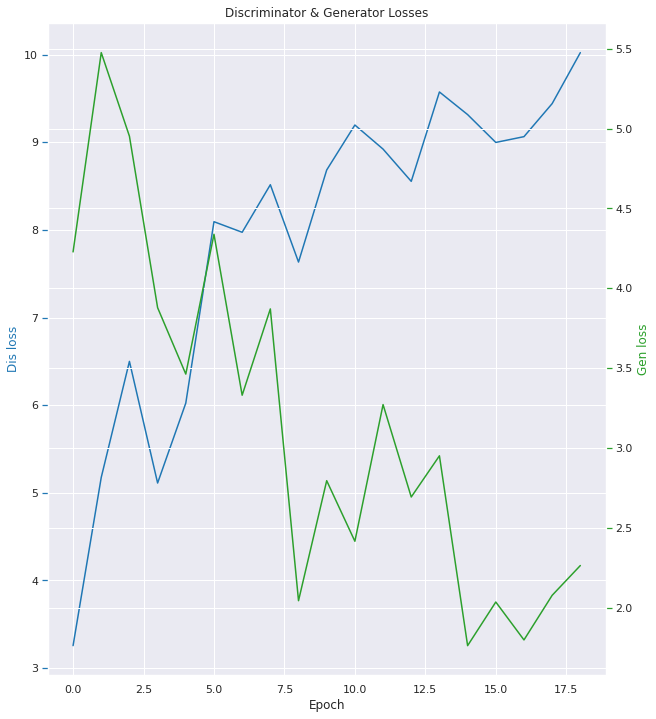


 10.839195 2.8202531

 10.839195 2.8202531

 10.839195 2.8202531


In [31]:
model_srgan.train(20, save_interval=2, batch_size=2)

In [0]:
def plot_predict(low_reso_imgs,high_reso_imgs,srgan_model,n_imgs = 1):
    plt.figure(figsize = (12,12))
    plt.tight_layout()
    for i in range(0,n_imgs*3,3):
        idx = np.random.randint(0,low_reso_imgs.shape[0]-1)
        plt.subplot(n_imgs,3,i+1)
        plt.imshow(high_reso_imgs[idx].astype('uint8'), interpolation='kaiser', aspect=0.65)
        plt.grid('off')
        plt.axis('off')
        plt.title('Source')
        plt.subplot(n_imgs,3,i+2)
        plt.imshow(cv2.resize(low_reso_imgs[idx],(720,720),
                          interpolation = cv2.INTER_CUBIC).astype('uint8'), interpolation='kaiser', aspect=0.65)
        plt.grid('off')
        plt.axis('off')
        plt.title('X4 (bicubic)')
        
        img = srgan_model.generator.predict(np.expand_dims(low_reso_imgs[idx], axis = 0) / 127.5 - 1)
        img_unnorm = (img+1) * 127.5
        plt.subplot(n_imgs,3,i+3)
        plt.imshow(np.squeeze(img_unnorm, axis = 0).astype(np.uint8),  aspect=0.65)
        plt.grid('off')
        plt.axis('off')
        plt.title('SRGAN')
    plt.tight_layout()   
    plt.savefig('predicted.png', dpi=200)

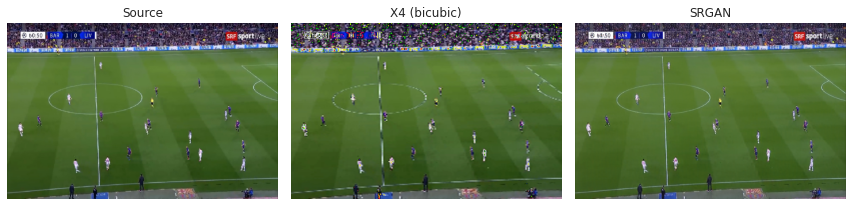

In [41]:
# Load pretrained model
#model_srgan.srgan.load_weights('/content/drive/My Drive/Fifa_CycleGan/SRGAN/srgan_weights_epoch_20.h5')
plot_predict(low_reso_imgs,high_reso_imgs,model_srgan)

In [0]:
img = model_srgan.generator.predict(np.expand_dims(low_reso_imgs[1], axis = 0) / 127.5 - 1)

# Upscale FIFA CycleGAN output


In [0]:
#model_srgan = SRGAN()
model_srgan.srgan.load_weights('/content/drive/My Drive/Fifa_CycleGan/SRGAN/srgan_weights_epoch_8.h5')
img_new = model_srgan.generator.predict(np.expand_dims(img_cyclegan_resized, axis = 0) / 127.5 - 1)
img_unnorm = (img_new+1) * 127.5

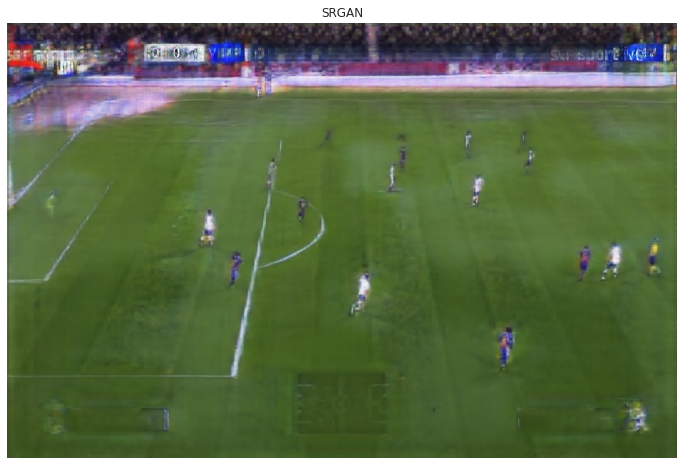

In [0]:
plt.figure(figsize=(12,10))
plt.imshow(np.squeeze(img_unnorm, axis = 0).astype(np.uint8),  aspect=0.65)
plt.grid('off')
plt.axis('off')
plt.title('SRGAN')
plt.show()